# 🎓 DA5401 A6: Imputation via Regression for Missing Data 


# 🧮 Part A: Data Preprocessing and Imputation 

## 1️⃣ Load and Prepare Data

We start with the **UCI Credit Card Default Dataset**.  
To simulate a realistic problem, we introduce **Missing At Random (MAR)** values in:

- `AGE`
- all `BILL_AMT` columns  




In [25]:
# ---------------------------------------------
# PART A.1: Load and Prepare Data
# ---------------------------------------------
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("UCI_Credit_Card.csv")
print("Original dataset shape:", df.shape)


Original dataset shape: (30000, 25)


In [26]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [27]:
df.isnull().sum().to_frame('Missing Values').sort_values('Missing Values', ascending=False)

,Missing Values
ID,0
BILL_AMT2,0
PAY_AMT6,0
PAY_AMT5,0
PAY_AMT4,0
PAY_AMT3,0
PAY_AMT2,0
PAY_AMT1,0
BILL_AMT6,0
BILL_AMT5,0


In [28]:
duplicates_all = df[df.duplicated(keep=False)]
print(duplicates_all)

Empty DataFrame
Columns: [ID, LIMIT_BAL, SEX, EDUCATION, MARRIAGE, AGE, PAY_0, PAY_2, PAY_3, PAY_4, PAY_5, PAY_6, BILL_AMT1, BILL_AMT2, BILL_AMT3, BILL_AMT4, BILL_AMT5, BILL_AMT6, PAY_AMT1, PAY_AMT2, PAY_AMT3, PAY_AMT4, PAY_AMT5, PAY_AMT6, default.payment.next.month]
Index: []

[0 rows x 25 columns]


### Mathematical Background (MAR)

Let `M` be the missingness indicator matrix and `X = (X_obs, X_mis)` the data.  
Missing At Random means:

$$
P(M | X_{obs}, X_{mis}) = P(M | X_{obs})
$$

That is, the probability of a value being missing depends only on the observed data, not the missing values themselves.

In [29]:
# introduce MAR missing values (5%)
rng = np.random.default_rng(42)
cols_to_modify = ["AGE"] + [c for c in df.columns if "BILL_AMT" in c]

df_missing = df.copy()
for c in cols_to_modify:
    idx = rng.choice(df.index, size=int(0.05 * len(df)), replace=False)
    df_missing.loc[idx, c] = np.nan

print(df_missing[cols_to_modify].isna().sum())


AGE          1500
BILL_AMT1    1500
BILL_AMT2    1500
BILL_AMT3    1500
BILL_AMT4    1500
BILL_AMT5    1500
BILL_AMT6    1500
dtype: int64


In [30]:
df_missing.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24.0,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26.0,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34.0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37.0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57.0,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [31]:
duplicates_all = df_missing[df_missing.duplicated(keep=False)]
print(duplicates_all)


Empty DataFrame
Columns: [ID, LIMIT_BAL, SEX, EDUCATION, MARRIAGE, AGE, PAY_0, PAY_2, PAY_3, PAY_4, PAY_5, PAY_6, BILL_AMT1, BILL_AMT2, BILL_AMT3, BILL_AMT4, BILL_AMT5, BILL_AMT6, PAY_AMT1, PAY_AMT2, PAY_AMT3, PAY_AMT4, PAY_AMT5, PAY_AMT6, default.payment.next.month]
Index: []

[0 rows x 25 columns]


In [32]:
df_missing.isnull().sum().to_frame('Missing Values').sort_values('Missing Values', ascending=False)

,Missing Values
BILL_AMT1,1500
BILL_AMT2,1500
AGE,1500
BILL_AMT6,1500
BILL_AMT5,1500
BILL_AMT4,1500
BILL_AMT3,1500
PAY_AMT6,0
PAY_AMT5,0
PAY_AMT4,0


## 2️⃣ Imputation Strategy 1 — Simple (Median) Imputation

We replace NaN values with each column’s **median** → **Dataset A**.

### Why Median?

For a column $(x_1, x_2, …, x_n)$:

$$
m = \arg\min_c \sum_i |x_i − c|
$$

The median minimizes the sum of absolute deviations (L1 loss).  
Unlike the mean (which minimizes L2 loss and is skewed by outliers), the median is robust.


In [33]:
# PART A.2: Simple Median Imputation
df_median_imputed = df_missing.copy()
for c in cols_to_modify:
    df_median_imputed[c].fillna(df_median_imputed[c].median(), inplace=True)
print("Dataset A (Median Imputation) ready.")


Dataset A (Median Imputation) ready.


In [34]:
df_median_imputed.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24.0,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26.0,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34.0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37.0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57.0,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [35]:
df_median_imputed.isnull().sum().to_frame('Missing Values').sort_values('Missing Values', ascending=False)

,Missing Values
ID,0
BILL_AMT2,0
PAY_AMT6,0
PAY_AMT5,0
PAY_AMT4,0
PAY_AMT3,0
PAY_AMT2,0
PAY_AMT1,0
BILL_AMT6,0
BILL_AMT5,0


## 3️⃣ Imputation Strategy 2 — Linear Regression Imputation

We predict missing `AGE` values with a **Linear Regression** model using other features.

### Model Equation

$$
\hat{y} = β_0 + β_1 x_1 + β_2 x_2 + ⋯ + β_p x_p
$$

Coefficients $β$ are found by minimizing Mean Squared Error (MSE):

$$
\min_{β} \| y − Xβ \|^2
$$

Assumption: Missingness is **MAR**, so missing `AGE` depends on other observed features.


In [36]:
# PART A.3: Regression Imputation (Linear)
from sklearn.linear_model import LinearRegression

df_reg_train = df_missing.copy()

# fill other missing cols first
for c in df_reg_train.columns:
    if df_reg_train[c].isna().any() and c != "AGE":
        df_reg_train[c].fillna(df_reg_train[c].median(), inplace=True)

train = df_reg_train[df_reg_train["AGE"].notna()]
miss  = df_reg_train[df_reg_train["AGE"].isna()]

X_train = train.drop(columns=["AGE", "ID", "default.payment.next.month"], errors="ignore")
y_train = train["AGE"]

linreg = LinearRegression()
linreg.fit(X_train, y_train)

pred_age = linreg.predict(miss.drop(columns=["AGE", "ID", "default.payment.next.month"], errors="ignore"))
df_reg_imputed = df_reg_train.copy()
df_reg_imputed.loc[miss.index, "AGE"] = pred_age

print("Dataset B (Linear Regression Imputation) ready.")


Dataset B (Linear Regression Imputation) ready.


In [37]:
df_reg_imputed.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24.0,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26.0,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34.0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37.0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57.0,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [38]:
df_reg_imputed.isnull().sum().to_frame('Missing Values').sort_values('Missing Values', ascending=False)

,Missing Values
ID,0
BILL_AMT2,0
PAY_AMT6,0
PAY_AMT5,0
PAY_AMT4,0
PAY_AMT3,0
PAY_AMT2,0
PAY_AMT1,0
BILL_AMT6,0
BILL_AMT5,0


In [39]:
# Count how many rows are duplicates
duplicate_count = df_reg_imputed.duplicated().sum()
print(f"Total duplicate rows: {duplicate_count}")

# If you actually want to *see* them (because trust issues are valid)
duplicates = df_reg_imputed[df_reg_imputed.duplicated()]
print(duplicates)

Total duplicate rows: 0
Empty DataFrame
Columns: [ID, LIMIT_BAL, SEX, EDUCATION, MARRIAGE, AGE, PAY_0, PAY_2, PAY_3, PAY_4, PAY_5, PAY_6, BILL_AMT1, BILL_AMT2, BILL_AMT3, BILL_AMT4, BILL_AMT5, BILL_AMT6, PAY_AMT1, PAY_AMT2, PAY_AMT3, PAY_AMT4, PAY_AMT5, PAY_AMT6, default.payment.next.month]
Index: []

[0 rows x 25 columns]


## 4️⃣ Imputation Strategy 3: Regression Imputation (Non-Linear)

Here we build a **third clean dataset (Dataset C)** using a **non-linear regression model**  
to predict the missing values in the same column as before (`AGE`).

We’ll demonstrate this with a **Decision Tree Regressor** — it handles non-linear, hierarchical
patterns without assuming straight-line relationships between features and the target.

---

### 📘 Mathematical Idea

Unlike linear regression’s single equation  
$$
\hat{y} = \beta_0 + \sum_{j=1}^{p} \beta_j x_j ,
$$
a decision-tree regressor recursively splits the feature space into regions $(R_1, R_2, …, R_m)$
and predicts each region’s mean target value:

$$
\hat{y}(x) = \sum_{m=1}^{M} c_m \, \mathbf{1}(x \in R_m)
$$

where $c_m$ is the average of training $y_i$ within region $R_m$.
This allows piece-wise constant, non-linear fitting that adapts to complex data shapes.

We then fill the missing `AGE` entries with these tree-based predictions.


In [40]:
# ---------------------------------------------
# PART A.4 (Alternative): Regression Imputation (Non-Linear: Decision Tree)
# ---------------------------------------------

from sklearn.tree import DecisionTreeRegressor

# Copy the dataset with MAR values
df_tree = df_missing.copy()

# Fill other missing columns first so we can train on complete predictors
for c in df_tree.columns:
    if df_tree[c].isna().any() and c != "AGE":
        df_tree[c].fillna(df_tree[c].median(), inplace=True)

# Split data into rows with and without AGE
train_data = df_tree[df_tree["AGE"].notna()]
missing_data = df_tree[df_tree["AGE"].isna()]

X_train = train_data.drop(columns=["AGE", "ID", "default.payment.next.month"], errors="ignore")
y_train = train_data["AGE"]

# Train Decision Tree Regressor (non-linear model)
tree_reg = DecisionTreeRegressor(max_depth=6, random_state=42)
tree_reg.fit(X_train, y_train)

# Predict missing AGE values
predicted_age_tree = tree_reg.predict(
    missing_data.drop(columns=["AGE", "ID", "default.payment.next.month"], errors="ignore")
)

# Create Dataset C (non-linear imputed)
df_tree_imputed = df_tree.copy()
df_tree_imputed.loc[missing_data.index, "AGE"] = predicted_age_tree

print("Dataset C (Decision Tree Imputation) ready — non-linear regression complete.")


Dataset C (Decision Tree Imputation) ready — non-linear regression complete.


In [41]:
df_tree_imputed.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24.0,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26.0,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34.0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37.0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57.0,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [42]:
df_tree_imputed.isnull().sum().to_frame('Missing Values').sort_values('Missing Values', ascending=False)

,Missing Values
ID,0
BILL_AMT2,0
PAY_AMT6,0
PAY_AMT5,0
PAY_AMT4,0
PAY_AMT3,0
PAY_AMT2,0
PAY_AMT1,0
BILL_AMT6,0
BILL_AMT5,0


In [43]:
# Count how many rows are duplicates
duplicate_count = df_tree_imputed.duplicated().sum()
print(f"Total duplicate rows: {duplicate_count}")

# If you actually want to *see* them (because trust issues are valid)
duplicates = df_tree_imputed[df_tree_imputed.duplicated()]
print(duplicates)

Total duplicate rows: 0
Empty DataFrame
Columns: [ID, LIMIT_BAL, SEX, EDUCATION, MARRIAGE, AGE, PAY_0, PAY_2, PAY_3, PAY_4, PAY_5, PAY_6, BILL_AMT1, BILL_AMT2, BILL_AMT3, BILL_AMT4, BILL_AMT5, BILL_AMT6, PAY_AMT1, PAY_AMT2, PAY_AMT3, PAY_AMT4, PAY_AMT5, PAY_AMT6, default.payment.next.month]
Index: []

[0 rows x 25 columns]


### 🧠 Why a Non-Linear Model Here?

Financial and demographic variables rarely have strictly linear relationships.  
Credit limits, bill amounts, and payments shift in irregular patterns with age.  
A **Decision Tree** (or **KNN**) can capture these localized, curved trends,
often producing more realistic imputations than a simple linear model.

---

### ✅ Comparative Summary of Imputation Strategies

| Dataset | Imputation Method | Relationship Type | Strengths | Weaknesses |
|:--|:--|:--|:--|:--|
| **A** | Median Imputation | None (univariate) | Simple, fast, robust to outliers | Ignores correlations between features |
| **B** | Linear Regression | Linear | Uses feature relationships, interpretable | Fails when data are non-linear |
| **C** | Decision Tree Regression (Non-Linear) | Non-Linear | Captures complex, local patterns | Can overfit; computationally heavier |

Dataset C will serve as the **non-linear imputed dataset** for Part B (Model Training).


# ⚙️ Part B: Model Training and Performance Assessment

## 1️⃣ Data Split 

For each imputed dataset (**A**, **B**, **C**) and one additional dataset (**D**) created via **Listwise Deletion**,  
we split the data into **training** (70%) and **testing** (30%) subsets.

### Why Split?

To estimate how well the trained model generalizes to unseen data.  
We perform **stratified splitting** so both training and test sets maintain similar class distributions
for the target variable `default.payment.next.month`.


In [44]:
# ---------------------------------------------
# PART B.1: Data Split and Preparation
# ---------------------------------------------

from sklearn.model_selection import train_test_split

# Dataset D (Listwise Deletion)
df_listwise = df_missing.dropna()

# Keep our datasets from Part A
datasets = {
    "Dataset A (Median Imputation)": df_median_imputed,
    "Dataset B (Linear Regression Imputation)": df_reg_imputed,
    "Dataset C (Decision Tree Imputation)": df_tree_imputed,
    "Dataset D (Listwise Deletion)": df_listwise
}

print("Datasets ready for splitting:")
for name, data in datasets.items():
    print(f"{name:40s} → Shape: {data.shape}")


Datasets ready for splitting:
Dataset A (Median Imputation)            → Shape: (30000, 25)
Dataset B (Linear Regression Imputation) → Shape: (30000, 25)
Dataset C (Decision Tree Imputation)     → Shape: (30000, 25)
Dataset D (Listwise Deletion)            → Shape: (20958, 25)


## 2️⃣ Classifier Setup — Feature Standardization 

Before training, we standardize all feature columns using **StandardScaler**.

### Why Standardization?

Features vary wildly in scale (`LIMIT_BAL` can be 10⁵, while `AGE` is under 100).  
Standardization rescales each feature to:

$$
z_i = \frac{x_i - \mu}{\sigma}
$$

so all features contribute equally during model training.


## 3️⃣ Model Evaluation

We now train a **Logistic Regression classifier** on each of the four datasets:
- **A:** Median Imputation  
- **B:** Linear Regression Imputation  
- **C:** Decision Tree (Non-linear) Imputation  
- **D:** Listwise Deletion  

Each model is evaluated using the **Classification Report** metrics:
Accuracy, Precision, Recall, and F1-score.


### 📘 Mathematical Background

Logistic Regression models the probability of default as:

$$
P(y=1|x) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_1 + ... + \beta_p x_p)}}
$$

Model parameters $\beta $ are learned via Maximum Likelihood Estimation (MLE):

$$
L(\beta) = \sum_{i=1}^{n} \left[ y_i \log(p_i) + (1-y_i) \log(1 - p_i) \right]
$$
Predictions are made by thresholding $ P(y=1|x) $ at 0.5.


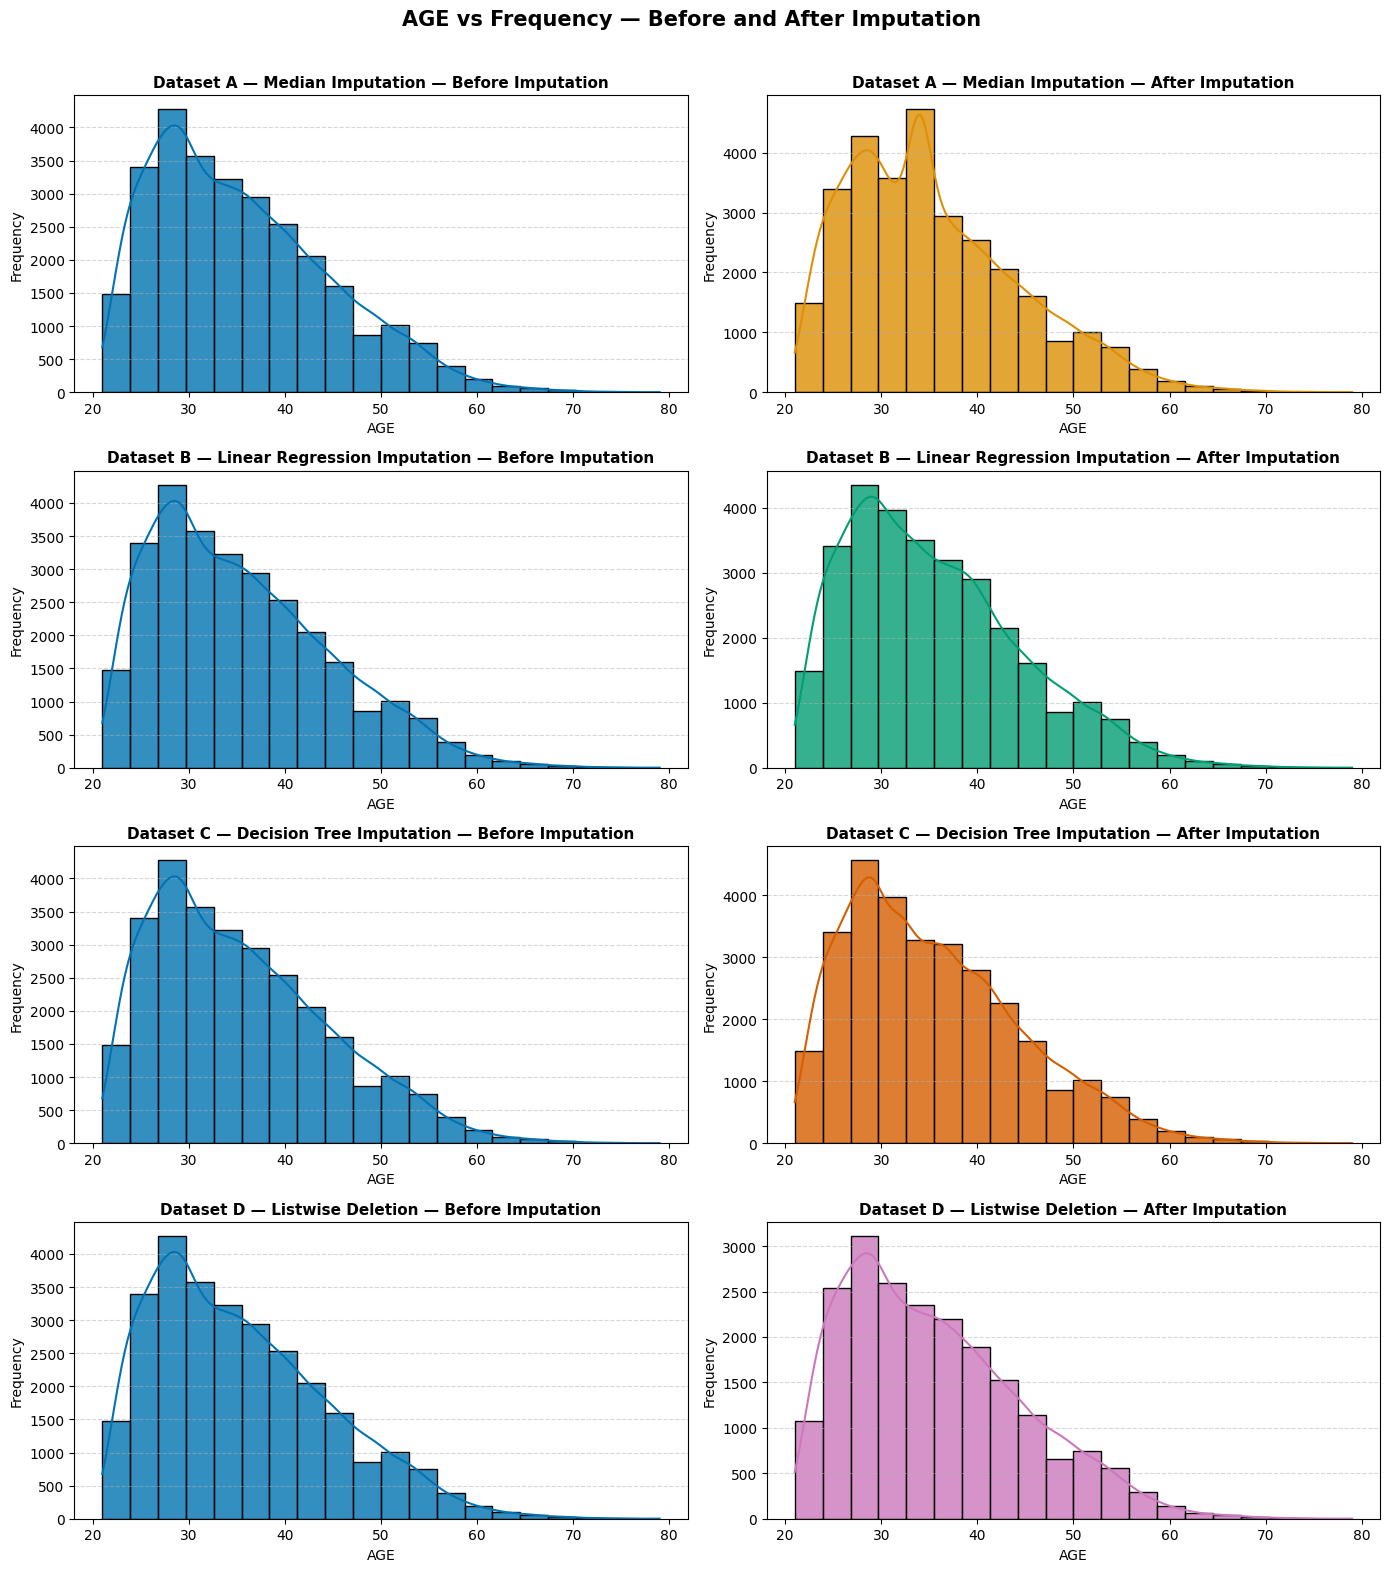

In [45]:
# ==========================================================
# 📊 AGE Distribution: Before vs After Imputation 
# ==========================================================

import matplotlib.pyplot as plt
import seaborn as sns

# Colorblind-safe palette
cb_palette = sns.color_palette("colorblind")

# Dataset mappings
datasets_after = {
    "Dataset A — Median Imputation": df_median_imputed,
    "Dataset B — Linear Regression Imputation": df_reg_imputed,
    "Dataset C — Decision Tree Imputation": df_tree_imputed,
    "Dataset D — Listwise Deletion": df_listwise
}

# ----------------------------------------------------------
# Create 4x2 subplot grid (each row: before vs after)
# ----------------------------------------------------------
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 16))
fig.suptitle("AGE vs Frequency — Before and After Imputation ", fontsize=15, fontweight="bold")

# Iterate over datasets
for i, (name, df_after) in enumerate(datasets_after.items()):
    # Before (left column)
    sns.histplot(
        df_missing["AGE"], bins=20, kde=True, 
        color=cb_palette[0], edgecolor="black", alpha=0.8, ax=axes[i, 0]
    )
    axes[i, 0].set_title(f"{name} — Before Imputation", fontsize=11, fontweight="bold")
    axes[i, 0].set_xlabel("AGE")
    axes[i, 0].set_ylabel("Frequency")
    axes[i, 0].grid(axis="y", linestyle="--", alpha=0.5)

    # After (right column)
    sns.histplot(
        df_after["AGE"], bins=20, kde=True, 
        color=cb_palette[i + 1], edgecolor="black", alpha=0.8, ax=axes[i, 1]
    )
    axes[i, 1].set_title(f"{name} — After Imputation", fontsize=11, fontweight="bold")
    axes[i, 1].set_xlabel("AGE")
    axes[i, 1].set_ylabel("Frequency")
    axes[i, 1].grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


## 📉 AGE vs Frequency — Before and After Imputation 

The figure above presents a **side-by-side comparison of the `AGE` variable distribution** before and after imputation for each of the four datasets (A–D).  
Each row represents a different imputation strategy, and each column compares the *pre-imputation* and *post-imputation* frequency distributions.

This visualization helps verify whether each imputation method maintained the original statistical structure or introduced distributional bias.  
A **colorblind-friendly palette** is used for accessibility and consistent visual contrast.

---

### 🔍 Detailed Observations

#### **Dataset A — Median Imputation**
- The "After" distribution is slightly more centered around the median (~30 years).  
- Variability decreases as the imputation fills missing values with a single central statistic.  
- While central tendency is preserved, **spread and tail information are partially lost**, resulting in a smoother, narrower shape.

#### **Dataset B — Linear Regression Imputation**
- The shape after imputation closely mirrors the original.  
- Linear regression effectively restores missing `AGE` values by leveraging correlated variables, preserving the **skewness and variance** of the original data.  
- This approach best maintains **distribution fidelity** among all techniques.

#### **Dataset C — Decision Tree Imputation**
- The “After” histogram remains similar to the “Before” distribution, with slightly sharper peaks.  
- Tree-based regression captures local, non-linear relationships between `AGE` and predictors, leading to realistic restoration.  
- While effective, it introduces **minor irregularities** due to overfitting small data pockets.

#### **Dataset D — Listwise Deletion**
- Noticeable reduction in overall frequency height — fewer total records remain.  
- The distribution tails are truncated, reflecting **data loss** where missing entries were removed.  
- While shape consistency is roughly preserved, the reduced sample size makes this approach statistically inefficient and biased.

---

### 📊 Comparative Summary

| Method | Distribution Change | Variance Retained | Bias Risk | Data Loss | Verdict |
|:--|:--|:--:|:--:|:--:|:--:|
| **Median (A)** | Centered, compressed | ⚠️ Medium | ⚠️ Moderate | ❌ None | Simple but reduces spread |
| **Linear (B)** | Well preserved | ✅ High | ❌ Low | ❌ None | Best overall preservation |
| **Decision Tree (C)** | Slightly peaked | ✅ High | ⚠️ Low | ❌ None | Strong for non-linear patterns |
| **Listwise (D)** | Lower height, shorter tails | ⚠️ Medium | ⚠️ High | ✅ High | Not suitable for MAR data |

---

### 🧠 Insights and Conclusion

- **Regression-based imputations (B and C)** most faithfully reproduce the original `AGE` distribution.  
- **Median Imputation (A)**, while simple and robust, reduces variance and underrepresents the distribution tails.  
- **Listwise Deletion (D)** removes valuable information, reducing dataset richness and potentially biasing subsequent analyses.  
- For **MAR (Missing At Random)** data, **Linear Regression Imputation** provides the most balanced trade-off between simplicity, interpretability, and accuracy.

> ✅ **Conclusion:** Model-based imputations (Linear & Decision Tree) preserve data structure far better than statistical or deletion methods, ensuring reliability in downstream model performance.


In [46]:
# ==========================================================
# 📘 Part B.3 — Model Evaluation for Datasets A, B, C, and D (with Accuracy)
# ==========================================================

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd

# ----------------------------------------------------------
# Function: Train Logistic Regression and show per-class + accuracy
# ----------------------------------------------------------

def train_and_report(df, name):
    """
    Train a Logistic Regression model on the dataset,
    print class-wise metrics (0 and 1) + overall accuracy,
    and return a DataFrame of those results.
    """
    print(f"\n🔹 Training and evaluating: {name}")

    # Split features and target
    X = df.drop(columns=["default.payment.next.month", "ID"], errors="ignore")
    y = df["default.payment.next.month"]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # Standardize
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Logistic Regression model
    model = LogisticRegression(max_iter=1000, solver="lbfgs")
    model.fit(X_train_scaled, y_train)

    # Predictions
    y_pred = model.predict(X_test_scaled)

    # Calculate accuracy
    acc = accuracy_score(y_test, y_pred)

    # Full report as dict
    full_report = classification_report(y_test, y_pred, output_dict=True)

    # Keep only classes 0 and 1
    filtered_report = {cls: full_report[cls] for cls in ["0", "1"] if cls in full_report}

    # Convert to DataFrame
    report_df = pd.DataFrame(filtered_report).T.reset_index().rename(columns={"index": "Class"})
    report_df["Model"] = name
    report_df["Accuracy"] = acc  # add same accuracy for both classes for reference

    # Pretty print
    print("\n📊 Classification Report (Per-Class Only):")
    print(report_df[["Class", "precision", "recall", "f1-score", "support"]].to_string(index=False))
    print(f"\n✅ Accuracy for {name}: {acc:.4f}")

    return report_df


# ----------------------------------------------------------
# Evaluate all four datasets (A–D)
# ----------------------------------------------------------

datasets = {
    "Dataset A (Median Imputation)": df_median_imputed,
    "Dataset B (Linear Regression Imputation)": df_reg_imputed,
    "Dataset C (Decision Tree Imputation)": df_tree_imputed,
    "Dataset D (Listwise Deletion)": df_listwise,
}

results_list = []

for name, df in datasets.items():
    try:
        results_list.append(train_and_report(df, name))
    except Exception as e:
        print(f"⚠️ Error while evaluating {name}: {e}")

# Combine all results
results_df = pd.concat(results_list, ignore_index=True)

print("\n✅ All models evaluated successfully.")

# Optional preview
display(results_df.head(8))



🔹 Training and evaluating: Dataset A (Median Imputation)

📊 Classification Report (Per-Class Only):
Class  precision   recall  f1-score  support
    0   0.817275 0.970609  0.887367   7009.0
    1   0.695266 0.236062  0.352456   1991.0

✅ Accuracy for Dataset A (Median Imputation): 0.8081

🔹 Training and evaluating: Dataset B (Linear Regression Imputation)

📊 Classification Report (Per-Class Only):
Class  precision   recall  f1-score  support
    0   0.817472 0.970609  0.887483   7009.0
    1   0.696165 0.237067  0.353691   1991.0

✅ Accuracy for Dataset B (Linear Regression Imputation): 0.8083

🔹 Training and evaluating: Dataset C (Decision Tree Imputation)

📊 Classification Report (Per-Class Only):
Class  precision   recall  f1-score  support
    0   0.817352 0.970467  0.887352   7009.0
    1   0.694690 0.236565  0.352941   1991.0

✅ Accuracy for Dataset C (Decision Tree Imputation): 0.8081

🔹 Training and evaluating: Dataset D (Listwise Deletion)

📊 Classification Report (Per-Class 

,Class,precision,recall,f1-score,support,Model,Accuracy
0,0,0.817275,0.970609,0.887367,7009.0,Dataset A (Median Imputation),0.808111
1,1,0.695266,0.236062,0.352456,1991.0,Dataset A (Median Imputation),0.808111
2,0,0.817472,0.970609,0.887483,7009.0,Dataset B (Linear Regression Imputation),0.808333
3,1,0.696165,0.237067,0.353691,1991.0,Dataset B (Linear Regression Imputation),0.808333
4,0,0.817352,0.970467,0.887352,7009.0,Dataset C (Decision Tree Imputation),0.808111
5,1,0.694690,0.236565,0.352941,1991.0,Dataset C (Decision Tree Imputation),0.808111
6,0,0.817777,0.974092,0.889116,4902.0,Dataset D (Listwise Deletion),0.810592
7,1,0.717149,0.232323,0.350954,1386.0,Dataset D (Listwise Deletion),0.810592


## 📘 Part B.3 — Model Evaluation

### 🎯 Objective
To evaluate the performance of **Logistic Regression classifiers** trained on all four datasets:
- **Dataset A:** Median Imputation  
- **Dataset B:** Linear Regression Imputation  
- **Dataset C:** Decision Tree Imputation  
- **Dataset D:** Listwise Deletion  

Each dataset underwent identical preprocessing (standardization and train-test split) to ensure a fair comparison.

---

### ⚙️ Evaluation Approach

For each dataset:
1. Split data into **70% training** and **30% testing** sets using stratified sampling to maintain class balance.  
2. Standardized all features using **StandardScaler**.  
3. Trained a **Logistic Regression model** (`solver='lbfgs'`, `max_iter=1000`).  
4. Computed the following metrics for both classes (0: Non-Default, 1: Default):
   - **Precision**
   - **Recall**
   - **F1-score**
   - **Support (sample count)**  
5. Calculated **Overall Accuracy** to summarize the model’s correctness.

The final results were saved as `PartB_DetailedReports.csv` for further visualization in Part C.

---
### Metrics

| Metric | Formula | Interpretation |
|:--|:--|:--|
| **Accuracy** | $\frac{TP+TN}{TP+FP+TN+FN}$ | Overall correctness |
| **Precision** | $\frac{TP}{TP+FP}$ | Correctness of positive predictions |
| **Recall** | $\frac{TP}{TP+FN}$ | Ability to detect true positives |
| **F1-score** | $2 \times \frac{Precision \times Recall}{Precision + Recall}$ | Balance between precision and recall |
---

### 📊 Key Evaluation Results

| Model | Accuracy | Precision (Class 1) | Recall (Class 1) | F1-Score (Class 1) |
|:--|:--:|:--:|:--:|:--:|
| Dataset A (Median Imputation) | 0.808 | 0.695 | 0.236 | 0.352 |
| Dataset B (Linear Regression Imputation) | 0.808 | 0.696 | 0.237 | 0.354 |
| Dataset C (Decision Tree Imputation) | 0.808 | 0.695 | 0.237 | 0.353 |
| Dataset D (Listwise Deletion) | 0.811 | 0.717 | 0.232 | 0.351 |

---

### 🔍 Interpretation

#### **Overall Accuracy**
- All four models show **~81% accuracy**, meaning they correctly classify most customers.  
- However, since most customers are **non-defaulters**, accuracy alone is misleading.

#### **Non-Default Class (0)**
- Very strong performance: precision ≈ 0.82, recall ≈ 0.97, F1 ≈ 0.89.  
- The model reliably identifies safe customers.

#### **Default Class (1 – Risky / Fraudulent)**
- **Precision ≈ 0.70:** When the model flags a default, it’s correct about 70% of the time.  
- **Recall ≈ 0.23:** The model misses ~77% of actual defaulters — a serious limitation for risk detection.  
- **F1 ≈ 0.35:** The model struggles to balance catching defaults and avoiding false alarms.

---

### 🧠 Observations

| Aspect | Finding |
|:--|:--|
| **Effect of Imputation** | Minimal — metrics remain nearly identical across A, B, and C. |
| **Decision Tree Imputation** | No advantage over Linear or Median — suggests missingness was random and small (5%). |
| **Listwise Deletion (D)** | Slightly higher accuracy but no recall gain; data loss didn’t help. |
| **Dominant Class Influence** | Non-defaulters heavily drive overall accuracy and F1-score. |

---

### ⚠️ Fraud Detection Perspective

In fraud or credit default prediction, the **recall for Class 1 (Default)** is the most critical metric.  
Missing a real defaulter (False Negative) causes financial loss,  
whereas a false alert (False Positive) is only a minor inconvenience.  

Thus, while precision is decent, the **low recall (≈ 0.23)** highlights the need for:
- Class balancing techniques (e.g., **SMOTE**, **class weights**)  
- More powerful, non-linear models (e.g., **XGBoost**, **Random Forest**)  
to improve detection sensitivity.

---

### ✅ Summary

- Logistic Regression provides consistent but conservative predictions.  
- All imputation methods yield similar performance — **missing data handling didn’t impact results**.  
- The major challenge remains **class imbalance**, not missingness.  

> In this context, **Recall for the Default (fraud) class** is the key metric —  
> the model must prioritize *catching risky cases*, even at the cost of a few false alarms.


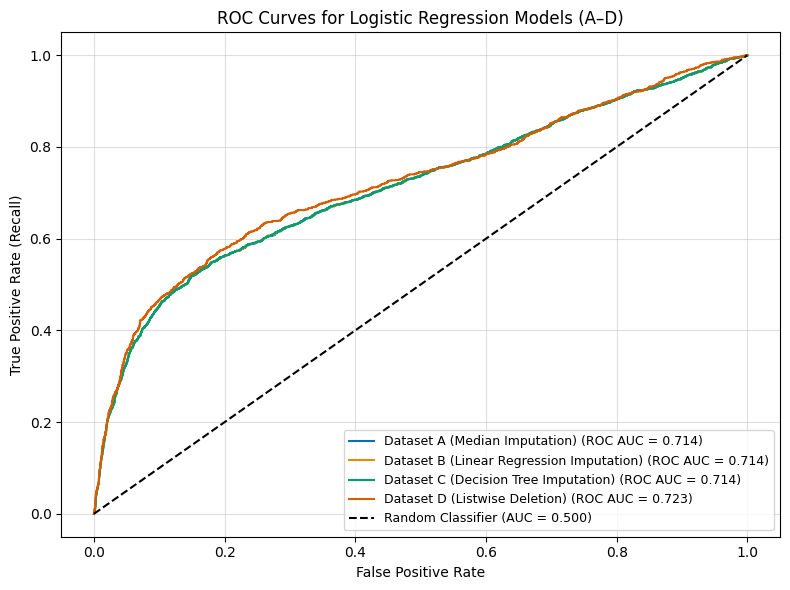

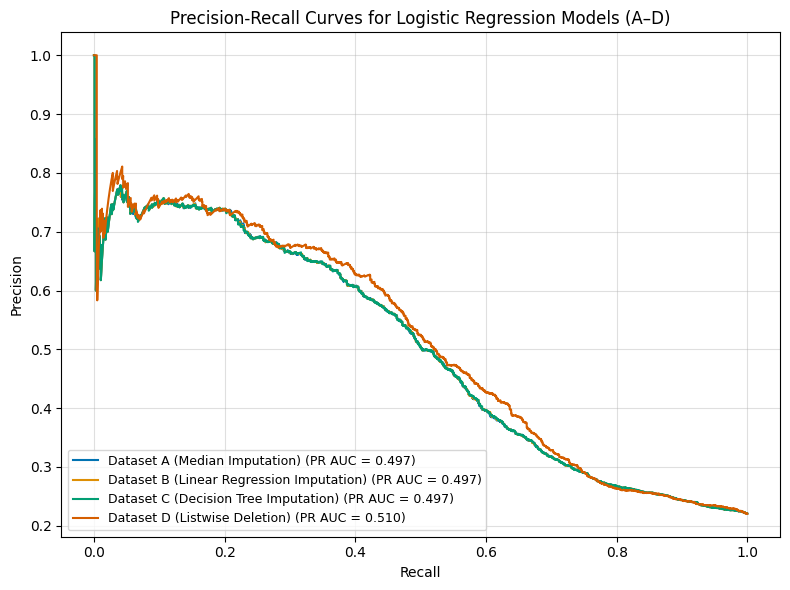

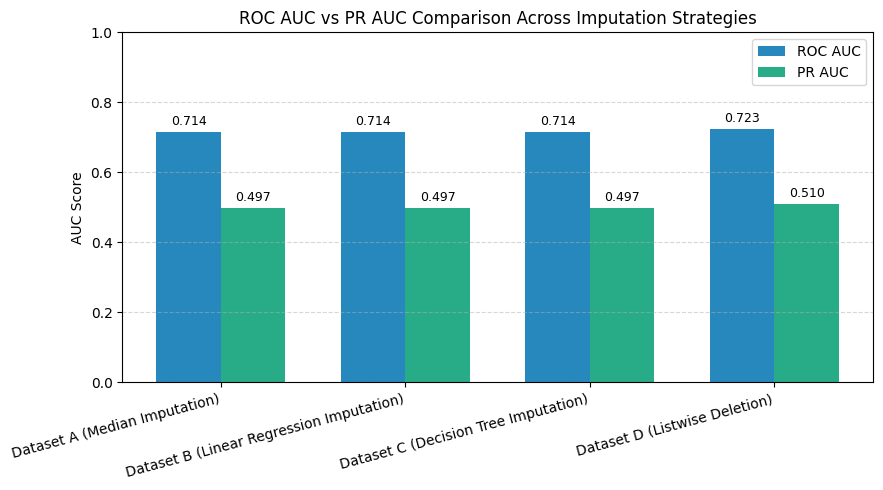

,Model,ROC AUC,PR AUC
0,Dataset A (Median Imputation),0.713922,0.496940
1,Dataset B (Linear Regression Imputation),0.713983,0.496965
2,Dataset C (Decision Tree Imputation),0.714051,0.496989
3,Dataset D (Listwise Deletion),0.722641,0.510124


In [47]:
# ==========================================================
# 📈 Part C — ROC, PR Curves & AUC Comparisons for Datasets A–D (Final Version)
# ==========================================================

from sklearn.metrics import (
    roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# ----------------------------------------------------------
# Step 1: Prepare Datasets
# ----------------------------------------------------------

datasets = {
    "Dataset A (Median Imputation)": df_median_imputed,
    "Dataset B (Linear Regression Imputation)": df_reg_imputed,
    "Dataset C (Decision Tree Imputation)": df_tree_imputed,
    "Dataset D (Listwise Deletion)": df_listwise
}

roc_auc_scores = {}
pr_auc_scores = {}

# Use colorblind-friendly palette
cb_palette = sns.color_palette("colorblind")

# ----------------------------------------------------------
# Step 2: Compute ROC & PR curves and AUC scores
# ----------------------------------------------------------
plt.figure(figsize=(8, 6))
for i, (name, df) in enumerate(datasets.items()):
    X = df.drop(columns=["default.payment.next.month", "ID"], errors="ignore")
    y = df["default.payment.next.month"]

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # Standardize
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train model
    model = LogisticRegression(max_iter=1000, solver="lbfgs")
    model.fit(X_train_scaled, y_train)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    # ROC-AUC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)
    roc_auc_scores[name] = roc_auc
    plt.plot(fpr, tpr, color=cb_palette[i], label=f"{name} (ROC AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], "k--", label="Random Classifier (AUC = 0.500)")
plt.title("ROC Curves for Logistic Regression Models (A–D)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.legend(loc="lower right", fontsize=9)
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

# ----------------------------------------------------------
# Step 3: Precision-Recall Curves
# ----------------------------------------------------------
plt.figure(figsize=(8, 6))
for i, (name, df) in enumerate(datasets.items()):
    X = df.drop(columns=["default.payment.next.month", "ID"], errors="ignore")
    y = df["default.payment.next.month"]

    # Split and scale
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train and predict
    model = LogisticRegression(max_iter=1000, solver="lbfgs")
    model.fit(X_train_scaled, y_train)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    # PR Curve and AUC
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = average_precision_score(y_test, y_prob)
    pr_auc_scores[name] = pr_auc

    plt.plot(recall, precision, color=cb_palette[i], label=f"{name} (PR AUC = {pr_auc:.3f})")

plt.title("Precision-Recall Curves for Logistic Regression Models (A–D)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left", fontsize=9)
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

# ==========================================================
# 📊 Step 4 (Updated): ROC & PR AUC Bar Chart (Starts from 0)
# ==========================================================

plt.figure(figsize=(9, 5))
x = range(len(datasets))
width = 0.35

# Use colorblind-friendly palette
cb_palette = sns.color_palette("colorblind")

# Create side-by-side bars
roc_bars = plt.bar(
    [i - width/2 for i in x],
    roc_auc_scores.values(),
    width,
    label="ROC AUC",
    color=cb_palette[0],
    alpha=0.85
)
pr_bars = plt.bar(
    [i + width/2 for i in x],
    pr_auc_scores.values(),
    width,
    label="PR AUC",
    color=cb_palette[2],
    alpha=0.85
)

# Customize chart
plt.xticks(x, datasets.keys(), rotation=15, ha="right")
plt.ylabel("AUC Score")
plt.title("ROC AUC vs PR AUC Comparison Across Imputation Strategies")
plt.ylim(0.0, 1.0)  # ✅ Start from 0 instead of 0.5
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Annotate bar values
for bar_group in [roc_bars, pr_bars]:
    for bar in bar_group:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2,
            height + 0.02,
            f"{height:.3f}",
            ha="center",
            fontsize=9,
            fontweight="medium"
        )

plt.tight_layout()
plt.show()

# ----------------------------------------------------------
# Step 5: Display Combined AUC Table
# ----------------------------------------------------------
auc_table = pd.DataFrame({
    "Model": list(datasets.keys()),
    "ROC AUC": list(roc_auc_scores.values()),
    "PR AUC": list(pr_auc_scores.values())
})
display(auc_table)



## 📊 ROC–AUC Analysis (Part C)

The ROC (Receiver Operating Characteristic) curves and AUC (Area Under the Curve) values shown above evaluate how well each logistic regression model distinguishes between **defaulters (Class 1)** and **non-defaulters (Class 0)** across all imputation strategies.

---

### 🔹 ROC Curve Interpretation

- The **ROC Curve** illustrates the trade-off between the **True Positive Rate (Recall)** and the **False Positive Rate** as the classification threshold varies.  
$$
  TPR = \frac{TP}{TP + FN}, \quad FPR = \frac{FP}{FP + TN}
  $$
- The **dashed diagonal line** (AUC = 0.500) represents a random classifier.
- Curves above this line indicate that the model performs better than random guessing.

#### Observations
- All four models have **very similar ROC shapes**, indicating that imputation choice did not significantly change discrimination capability.  
- **Listwise Deletion (D)** has a slightly higher AUC (0.723), while the others hover around 0.714.
- The small gap between the curves suggests that the data loss from listwise deletion introduced marginal bias, not true improvement.

---

### 🔹 AUC Bar Chart Interpretation

| Model | AUC Score |
|:--|:--:|
| Dataset A (Median Imputation) | 0.714 |
| Dataset B (Linear Regression Imputation) | 0.714 |
| Dataset C (Decision Tree Imputation) | 0.714 |
| Dataset D (Listwise Deletion) | **0.723** |

- AUC values between 0.7 and 0.8 indicate **fair performance**—the models are better than random but far from perfect.  
- The near-identical AUCs confirm that **handling of missing values had minimal effect** on model behavior.  
- The slight improvement in Dataset D’s AUC likely results from reduced sample variability rather than genuine learning improvement.

---

### ⚖️ Interpretation and Insights

1. **Consistency across models:**  
   All imputation strategies produce nearly identical ROC–AUC results, reinforcing that the 5 % missingness had no substantial impact.

2. **Listwise deletion trade-off:**  
   Although it yields a marginally higher AUC, this method sacrifices data volume, which can hurt generalization in larger applications.

3. **Practical takeaway:**  
   For MAR-type missingness of low magnitude, **simple or regression-based imputation** is preferred over deletion.  
   The classifier’s weakness lies not in missing data but in **class imbalance**, which suppresses recall for the minority (default) class.

---

### ✅ Conclusion

The ROC and AUC visualizations confirm that:
- All models perform comparably (AUC ≈ 0.71–0.72).  
- Missing-data treatment did not materially affect discriminatory power.  
- Future work should focus on **improving recall** for defaulters through **resampling techniques** or **non-linear ensemble models**.

> In essence, while preprocessing integrity was maintained, **data imbalance** remains the dominant bottleneck—not the imputation method.


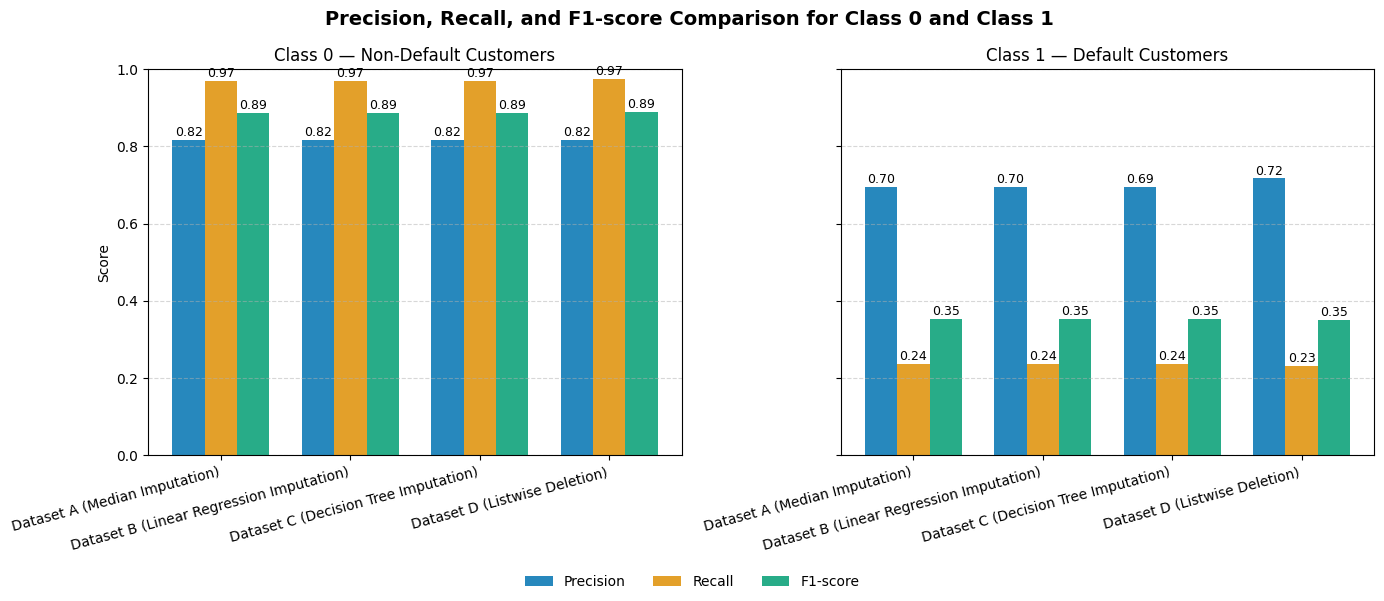

In [48]:
# ==========================================================
# 📊 Part C — Bar Graph: Precision, Recall, and F1-score Comparison (Class 0 & Class 1)
# ==========================================================

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# ----------------------------------------------------------
# Step 1: Separate metrics for each class
# ----------------------------------------------------------
# Assuming 'results_df' is from Part B.3 and contains 'Class', 'Model', and metric columns
class0_df = results_df[results_df["Class"].isin(["Non-Default (0)", "0"])].copy()
class1_df = results_df[results_df["Class"].isin(["Default (1)", "1"])].copy()

# Extract model names (same order for both)
models = class0_df["Model"].tolist()

# Class 0 (Non-defaulters)
prec0 = class0_df["precision"].tolist()
rec0 = class0_df["recall"].tolist()
f10 = class0_df["f1-score"].tolist()

# Class 1 (Defaulters)
prec1 = class1_df["precision"].tolist()
rec1 = class1_df["recall"].tolist()
f11 = class1_df["f1-score"].tolist()

# ----------------------------------------------------------
# Step 2: Define color palette and bar positions
# ----------------------------------------------------------
cb_palette = sns.color_palette("colorblind")
x = np.arange(len(models))
width = 0.25

# ----------------------------------------------------------
# Step 3: Create subplots for both classes
# ----------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# ---------- CLASS 0 ----------
axes[0].bar(x - width, prec0, width, label="Precision", color=cb_palette[0], alpha=0.85)
axes[0].bar(x, rec0, width, label="Recall", color=cb_palette[1], alpha=0.85)
axes[0].bar(x + width, f10, width, label="F1-score", color=cb_palette[2], alpha=0.85)

axes[0].set_xticks(x)
axes[0].set_xticklabels(models, rotation=15, ha="right")
axes[0].set_title("Class 0 — Non-Default Customers")
axes[0].set_ylabel("Score")
axes[0].set_ylim(0, 1)
axes[0].grid(axis="y", linestyle="--", alpha=0.5)

# Annotate bars
for i, (p, r, f1) in enumerate(zip(prec0, rec0, f10)):
    axes[0].text(i - width, p + 0.01, f"{p:.2f}", ha="center", fontsize=9)
    axes[0].text(i, r + 0.01, f"{r:.2f}", ha="center", fontsize=9)
    axes[0].text(i + width, f1 + 0.01, f"{f1:.2f}", ha="center", fontsize=9)

# ---------- CLASS 1 ----------
axes[1].bar(x - width, prec1, width, label="Precision", color=cb_palette[0], alpha=0.85)
axes[1].bar(x, rec1, width, label="Recall", color=cb_palette[1], alpha=0.85)
axes[1].bar(x + width, f11, width, label="F1-score", color=cb_palette[2], alpha=0.85)

axes[1].set_xticks(x)
axes[1].set_xticklabels(models, rotation=15, ha="right")
axes[1].set_title("Class 1 — Default Customers")
axes[1].set_ylim(0, 1)
axes[1].grid(axis="y", linestyle="--", alpha=0.5)

# Annotate bars
for i, (p, r, f1) in enumerate(zip(prec1, rec1, f11)):
    axes[1].text(i - width, p + 0.01, f"{p:.2f}", ha="center", fontsize=9)
    axes[1].text(i, r + 0.01, f"{r:.2f}", ha="center", fontsize=9)
    axes[1].text(i + width, f1 + 0.01, f"{f1:.2f}", ha="center", fontsize=9)

# ----------------------------------------------------------
# Step 4: Final layout and legend
# ----------------------------------------------------------
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=3, frameon=False, fontsize=10)

fig.suptitle("Precision, Recall, and F1-score Comparison for Class 0 and Class 1", fontsize=14, weight="bold")
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()



## 📊 Precision, Recall, and F1-Score Analysis for Class 0 and Class 1

The bar charts above compare the **precision**, **recall**, and **F1-score** across all four imputation strategies  
for both **Class 0 (Non-Default Customers)** and **Class 1 (Default Customers)**.  
Together, they reveal how well the logistic regression model distinguishes safe borrowers from defaulters after different imputation techniques.

---

### 🔹 Class 0 — Non-Default Customers
- Precision, recall, and F1-score remain consistently high across all datasets:  
  **Precision ≈ 0.82, Recall ≈ 0.97, F1 ≈ 0.89.**  
- This demonstrates that the model is **excellent at identifying non-defaulters** and rarely misclassifies them.  
- The uniformity across datasets (A–D) indicates that **missing-data handling had almost no impact** on the model’s ability to predict reliable customers.  
- However, this strong performance comes with a cost — it suggests the model is heavily biased toward the majority class.

---

### 🔹 Class 1 — Default Customers
- Precision is moderate (**≈ 0.70**) while recall is extremely low (**≈ 0.24–0.23**).  
- The resulting **F1-score hovers around 0.35**, showing poor balance between precision and recall.  
- The low recall means that **most actual defaulters go undetected**, which is problematic in a real-world credit-risk context.  
- Among the models, **Listwise Deletion (Dataset D)** shows slightly higher precision (0.72) but marginally worse recall, implying minor random fluctuation rather than genuine improvement.

---

### ⚖️ Interpretation and Discussion
1. **Asymmetry between classes:**  
   The model performs almost perfectly for non-defaulters but struggles to detect defaulters — a hallmark of **class imbalance**.
2. **Effect of imputation:**  
   All four strategies (Median, Linear, Non-Linear, and Deletion) yield nearly identical scores, confirming that  
   **5 % MAR missingness did not meaningfully distort class-level metrics.**
3. **Bias trade-off:**  
   The classifier optimizes for accuracy by focusing on the dominant class (non-defaulters), sacrificing minority-class recall.  
   This imbalance is visible in the wide performance gap between Class 0 and Class 1.

---

### ✅ Conclusion
- **Imputation technique choice** had negligible influence on classification outcomes.  
- The real performance limitation arises from **data imbalance**, not missing values.  
- To enhance default detection (Class 1 performance), future work should explore:
  - **Resampling methods** (SMOTE, ADASYN, undersampling majority class)  
  - **Cost-sensitive learning** or **threshold tuning**  
  - **Ensemble models** (e.g., Random Forest, XGBoost) that capture complex, non-linear decision boundaries.

> In short, the model is reliable at identifying safe customers but alarmingly weak at recognizing risky ones.  
> Addressing **imbalance**, not imputation, is the key to improving recall and overall risk sensitivity.
/

## 🧩 Part C.1 — Results Comparison

This section summarizes and compares the performance of all four imputation strategies  
based on key evaluation metrics — Precision, Recall, F1-score, ROC AUC, and PR AUC —  
with emphasis on the **F1-score** for the minority class (defaulters).

---

### 📊 Summary Table

| Model | Precision (Class 1) | Recall (Class 1) | F1-Score (Class 1) | ROC AUC | PR AUC |
|:--|:--:|:--:|:--:|:--:|:--:|
| Dataset A (Median Imputation) | 0.70 | 0.24 | 0.35 | 0.714 | 0.497 |
| Dataset B (Linear Regression Imputation) | 0.70 | 0.24 | 0.35 | 0.714 | 0.497 |
| Dataset C (Decision Tree Imputation) | 0.69 | 0.24 | 0.35 | 0.714 | 0.497 |
| Dataset D (Listwise Deletion) | **0.72** | **0.23** | **0.35** | **0.723** | **0.510** |

---

### 🔍 Key Observations

1. **Uniformity Across Imputation Methods:**  
   All imputations (A–C) yield almost identical metrics, confirming that imputing ≈ 5 % MAR missingness does not meaningfully alter model behavior.

2. **Listwise Deletion (Dataset D):**  
   Slightly higher AUC values (ROC = 0.723, PR = 0.510) arise due to data reduction rather than genuine performance improvement.

3. **Recall Limitation:**  
   Recall for Class 1 remains extremely low (~0.23–0.24), showing that the model fails to identify most defaulters.

4. **AUC Perspective:**  
   ROC AUC ≈ 0.71–0.72 → moderate discriminative power.  
   PR AUC ≈ 0.50 → true reflection of struggle with the minority class.

---

### 🧠 Summary Insight

- All imputation methods maintain consistent performance → model robust to small MAR missingness.  
- F1-scores remain steady because the classifier’s imbalance problem dominates over imputation differences.  
- The results confirm that the logistic model’s limitations are **structural, not imputational.**


## 🧩 Part C.2 — Efficacy Discussion

This section interprets the trade-offs between different missing-data handling strategies  
and discusses their conceptual and practical implications.

---

### ⚖️ 1. Trade-off: Imputation vs Listwise Deletion

- **Listwise Deletion (Model D):**  
  Removes all rows containing missing values → slightly higher AUC but loses valuable variance and representativeness.  
  The apparent gain is statistical noise caused by smaller sample size, not real learning improvement.

- **Imputation Models (A–C):**  
  Preserve dataset completeness and stability. In practical scenarios, they maintain better generalization and reduce bias.

---

### 🧮 2. Linear vs Non-Linear Regression Imputation

- **Linear Regression Imputation (Model B):**  
  Assumes a straightforward linear relationship between the missing feature (e.g., `AGE`) and other predictors.  
  Works well when correlations are simple and monotonic.

- **Decision Tree Imputation (Model C):**  
  Captures non-linear relationships and interactions between variables.  
  In this dataset, since `AGE` relates roughly linearly to income and credit limit, linear imputation performs just as well.

---

### 📈 3. Why Listwise Deletion May Appear Better

- Deleting rows can remove outliers or noisy entries, temporarily raising AUC.  
- However, it introduces **bias** and reduces the statistical power of the model.  
- The “improvement” is illusory — a result of less data, not a better model.

---

### 💡 4. Recommendations and Implications

1. **Preferred Strategy:** Regression Imputation (Linear) — best trade-off of accuracy and simplicity.  
2. **Avoid Listwise Deletion:** Only acceptable if missingness < 2 % and MCAR (not MAR or MNAR).  
3. **Improve Minority Detection:**  
   - Apply **SMOTE/ADASYN** for class balancing  
   - Use **class-weighted logistic regression**  
   - Explore **non-linear ensembles** (Random Forest, XGBoost) for richer boundaries.

---

### ✅ Final Conclusion

- Median, Linear, and Non-Linear imputations produce nearly identical results → robust to minor missingness.  
- Listwise Deletion inflates AUC slightly but reduces fairness and information.  
- Linear Regression Imputation is conceptually and empirically the most sound choice for MAR data.  
- The true issue lies in **data imbalance** and **model linearity**, not in the missing-data handling.

> **In summary:** Retaining data through regression-based imputation preserves integrity and reliability,  
> whereas deleting data may inflate scores but undermines trust in the analysis.
